### Prueba técnica - Itinerario Data Science con python.

# Notebook 3. Modelos de aprendizaje no supervisado y supervisado aplicados a los datos metereológicos. 

En este notebook voy a plantear dos tipos de aprendizaje automático, supervisado y no supervisado a los datos que descargamos y analizamos en el notebook anterior.

In [1]:
## Librerías

# Data wrangling
#-----------------------------------------------------------------------
import numpy as np
import pandas as pd


## Time series
##----------------------------------------------------------------
from statsmodels.tsa.seasonal import seasonal_decompose

## Visualización de datos
##----------------------------------------------------------------
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns


# MySQL conection
#-----------------------------------------------------------------------
import mysql.connector


# Librerías para visualización de modelos
#--------------------------------------------------
from kneed import KneeLocator

## Model selection
##----------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score 
from sklearn.feature_selection import RFECV, SelectKBest, RFE

## Preprocesing
##----------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

## Linear Models
##----------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Ensemble
##----------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline

## Model evaluation
##----------------------------------------------------------------
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_auc_score, confusion_matrix


import optuna

from joblib import dump, load


In [2]:
# Seaborn settings
sns.set_style("darkgrid")
sns.set_palette('RdGy')

## 1. Preparación del dataset.

En primer lugar voy a cargar los datos de la base de datos MySQL y los introduciré en un dataframe, para a continuación darle formato y preprocesar el dataset. 

### 1.1. Carga de los datos.

Cargamos los datos con la ayuda de la librería mysql.connector.

In [56]:
# Conection with localhost 
mydb = mysql.connector.connect(
  host='localhost',
  user='root',
  password='c4nionerou', 
  database='bcn_precipitaciones'
)

In [57]:
# Opnening a cursor
mycursor = mydb.cursor(dictionary=True)

In [58]:
# Query for extracting
query2 = '''SELECT * 
           FROM precipitaciones'''

In [59]:
mycursor.execute(query2)

In [60]:
DATA_b = mycursor.fetchall()
#DATA_b

In [61]:
DATA = pd.DataFrame(DATA_b)

In [62]:
mycursor.close()

True

In [63]:
mydb.commit()

### 1.2. Preprocesamiento del dataset.

Antes de aplicar los modelos de aprendizaje automático tenemos que seguir los siguientes pasos:
1. Dar formato correspondiente a cada campo.
2. Búsqueda de duplicados.
3. Tratamiento de valores perdidos.


In [11]:
# First lines
DATA.head(3)

,ID,fecha,precipitacion,horas_sol,presion_max,presion_min,temperatura_min,temperatura_max,velocidad_media
0,0,1992-01-01,0.0,6.6,1037.8,1033.6,11.6,0.3,7.92
1,1,1992-01-02,0.0,6.4,1038.6,1037.0,12.6,0.2,11.16
2,2,1992-01-03,0.3,1.0,1037.3,1032.7,12.2,2.3,7.92


In [12]:
# General info 
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10775 entries, 0 to 10774
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               10775 non-null  int64 
 1   fecha            10775 non-null  object
 2   precipitacion    10775 non-null  object
 3   horas_sol        10775 non-null  object
 4   presion_max      10775 non-null  object
 5   presion_min      10775 non-null  object
 6   temperatura_min  10775 non-null  object
 7   temperatura_max  10775 non-null  object
 8   velocidad_media  10775 non-null  object
dtypes: int64(1), object(8)
memory usage: 757.7+ KB


In [64]:
# fecha to datetime
DATA.fecha = pd.to_datetime(DATA.fecha,format='%Y-%m-%d' )

In [65]:
columnas = DATA.columns
# columns to numeric
for campo in columnas[2:]:
    DATA[campo] = pd.to_numeric(DATA[campo])

In [66]:
# General info after formating features
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10775 entries, 0 to 10774
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               10775 non-null  int64         
 1   fecha            10775 non-null  datetime64[ns]
 2   precipitacion    10693 non-null  float64       
 3   horas_sol        10285 non-null  float64       
 4   presion_max      10719 non-null  float64       
 5   presion_min      10718 non-null  float64       
 6   temperatura_min  10743 non-null  float64       
 7   temperatura_max  10743 non-null  float64       
 8   velocidad_media  10775 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 757.7 KB


In [67]:
# Duplicated rows
DATA[DATA.duplicated()].sum()

ID                 0.0
precipitacion      0.0
horas_sol          0.0
presion_max        0.0
presion_min        0.0
temperatura_min    0.0
temperatura_max    0.0
velocidad_media    0.0
dtype: float64

In [69]:
# Total percentage missing values 
(DATA.isna().sum()/DATA.shape[0]*100).round(2)

ID                 0.00
fecha              0.00
precipitacion      0.76
horas_sol          4.55
presion_max        0.52
presion_min        0.53
temperatura_min    0.30
temperatura_max    0.30
velocidad_media    0.00
dtype: float64

El porcentage de valores perdidos es en general inferior al 1% salvo en la variable horas de sol. Para tratar los valores perdidos voy a utilizar el siguiente enfoque:
- __precipitación__: como se trata de la variable objetivo y tenemos menos de un 1%, estos valores perdidos los voy a eliminar.

- __Resto de variables__: En este caso voy a interpolar los valores nulos, entender que el valor diario estará muy cerca del promedio de los días anterior y posterior.




In [70]:
# Dropping Missing values for target precipitacion
DATA.dropna(axis=0,
            subset=['precipitacion'], 
            inplace=True)

In [71]:
# Interpolating missing values for the other features
DATA.interpolate(inplace=True)

### 1.3. Nuevas variables.

In [72]:
# New feature mes
DATA['mes'] = DATA.fecha.dt.month

# New feature año
DATA['anio'] = DATA.fecha.dt.year


## 2. Aprendizaje no supervisado. Clustering.

En este apartado voy a aplicar un modelo de aprendizaje no supervisado para obtener agrupaciones de observaciones con objeto de encontrar algún patrón que no sea fácilmente visible.

In [23]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10693 entries, 0 to 10774
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               10693 non-null  int64         
 1   fecha            10693 non-null  datetime64[ns]
 2   precipitacion    10693 non-null  float64       
 3   horas_sol        10693 non-null  float64       
 4   presion_max      10693 non-null  float64       
 5   presion_min      10693 non-null  float64       
 6   temperatura_min  10693 non-null  float64       
 7   temperatura_max  10693 non-null  float64       
 8   velocidad_media  10693 non-null  float64       
 9   mes              10693 non-null  int64         
 10  anio             10693 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 1002.5 KB


In [24]:
# Data Preprocessing
#--------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

# Clustering
#--------------------------------------------------
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Metrics
#--------------------------------------------------
from sklearn.metrics import silhouette_score

from sklearn.pipeline import Pipeline


### 3.1. K-Means sin variables temporales.

Aplicaremos el algoritmo K-Means incluyendo solo las variables derivadas de la climatología, presiones, temperaturas, horas de sol y viento.

In [76]:
DATA.set_index('fecha', inplace=True)

In [77]:
DATA.drop(columns=['mes', 'anio', 'ID'], inplace=True)

In [37]:
Scaler=StandardScaler()
X_tr = Scaler.fit_transform(DATA)
#----------------------------------------------------------------

# Lista con la inercia según k
sse=[]

# Lista con el score silhouette coef.
sil_coeficient=[]

#----------------------------------------------------------------


for k in range(2,30):
    # Pipeline - Primer paso estandarizar / segundo paso Kmeans
    C_Kmean=Pipeline(steps=[('Estandarizar',StandardScaler()),
                            ('Cluster',KMeans(n_clusters=k,random_state=1987))])

    # Ajuste declustering Kmeans (k)
    C_Kmean.fit(DATA)
    
    # Inercia y lista con valores de inercia ordenado de k=2 a K=n
    inertia=C_Kmean[1].inertia_
    sse.append(inertia)
    
    # Silhouette score para cada k
    labels=C_Kmean[1].labels_
    sil=silhouette_score(X_tr, 
                         labels,
                         #sample_size=80000,random_state=1984
                        )
    sil_coeficient.append(sil)
    

In [38]:
kl=KneeLocator(range(2,30),sse,curve='convex',direction='decreasing')
kl.elbow

8

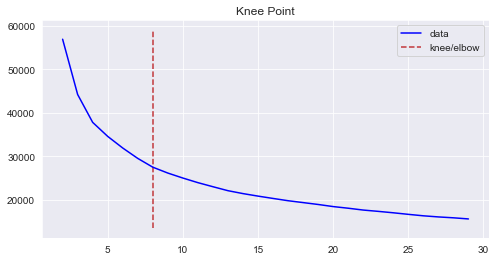

In [39]:
kl.plot_knee(figsize=(8,4))

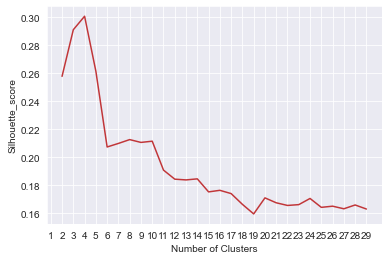

In [40]:
plt.plot(range(2, 30), sil_coeficient)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_score")
plt.show()

El método del codo me devuelve un valor óptimo de 8 clusters y silhouette score nos da un máximo de 0.3 con 4 clusters. 

In [41]:
# KMeans for k = 4
C_Kmean4 = Pipeline(steps=[('Estandarizar',StandardScaler()),
                           ('Cluster',KMeans(n_clusters=4,random_state=1987))])

DATA_c4 = C_Kmean4.fit(DATA)


### 3.2. KMeans con valores de mes y año.

Veamos si mejora el silhouete score con dos variables adicionales. Año y mes.

In [78]:
DATA.reset_index(inplace=True)

# New feature mes
DATA['mes'] = DATA.fecha.dt.month

# New feature año
DATA['anio'] = DATA.fecha.dt.year

DATA.set_index('fecha',inplace=True)

In [44]:
Scaler=StandardScaler()
X_tr = Scaler.fit_transform(DATA)
#----------------------------------------------------------------

# Lista con la inercia según k
sse=[]

# Lista con el score silhouette coef.
sil_coeficient=[]

#----------------------------------------------------------------


for k in range(2,30):
    # Pipeline - Primer paso estandarizar / segundo paso Kmeans
    C_Kmean=Pipeline(steps=[('Estandarizar',StandardScaler()),
                            ('Cluster',KMeans(n_clusters=k,random_state=1987))])

    # Ajuste declustering Kmeans (k)
    C_Kmean.fit(DATA)
    
    # Inercia y lista con valores de inercia ordenado de k=2 a K=n
    inertia=C_Kmean[1].inertia_
    sse.append(inertia)
    
    # Silhouette score para cada k
    labels=C_Kmean[1].labels_
    sil=silhouette_score(X_tr, 
                         labels,
                         #sample_size=80000,random_state=1984
                        )
    sil_coeficient.append(sil)
    

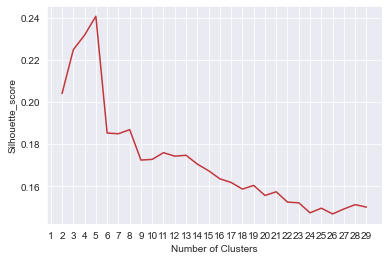

In [45]:
plt.plot(range(2, 30), sil_coeficient)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_score")
plt.show()

En este segundo caso silhouete score queda en torno a 0.24 con 5 clusters. Por lo que los grupos son algo más cohesionados en el primer caso.

### 3.3. Análisis de los clústers obtenidos con KMeans.

Vamos a analizar los grupos que nos propone el algoritmo KMeans, para ver que similitudes ha encontrado. Para ello, cargo las etiquetas de los clusters del modelo obtenido en el punto 3.1.

In [79]:
# Labels for clusters
DATA['cluster'] = DATA_c4[1].labels_

In [47]:
pd.options.display.max_columns=72
pd.options.display.max_rows=72

In [48]:
DATA.groupby('cluster').describe().T

cluster                          0            1            2            3
precipitacion   count  4597.000000  2574.000000  3292.000000   230.000000
                mean      0.472613     1.742813     0.337667    36.824348
                std       2.076946     3.736028     1.672129    18.990058
                min       0.000000     0.000000     0.000000    15.900000
                25%       0.000000     0.000000     0.000000    23.725000
                50%       0.000000     0.000000     0.000000    30.700000
                75%       0.000000     1.300000     0.000000    43.975000
                max      25.800000    21.200000    22.200000   134.700000
horas_sol       count  4597.000000  2574.000000  3292.000000   230.000000
                mean      8.888827     4.269634     5.918644     2.257815
                std       2.822592     3.366551     3.262226     3.126471
                min       0.000000     0.000000     0.000000     0.000000
                25%       7.400000     1.100000     3.500000     0.000000
                50%       9.700000     4.000000     6.300000     0.500000
                75%      11.000000     7.000000     8.400000     3.800000
                max      13.700000    13.100000    12.700000    11.100000
presion_max     count  4597.000000  2574.000000  3292.000000   230.000000
                mean   1017.949804  1012.553932  1025.115785  1014.268538
                std       3.342938     4.996665     4.430621     5.426723
                min    1005.000000   989.900000  1015.600000   999.200000
                25%    1015.800000  1009.600000  1021.700000  1010.725000
                50%    1018.000000  1013.300000  1024.600000  1014.200000
                75%    1020.200000  1016.200000  1028.200000  1017.875000
                max    1031.300000  1028.400000  1040.900000  1027.263636
presion_min     count  4597.000000  2574.000000  3292.000000   230.000000
                mean   1014.359996  1006.210570  1020.675825  1008.493597
                std       3.776616     5.728558     4.901264     6.659993
                min     998.900000   979.400000  1006.800000   986.200000
                25%    1011.900000  1002.900000  1016.900000  1004.525000
                50%    1014.500000  1007.200000  1020.200000  1008.850000
                75%    1016.900000  1010.600000  1023.900000  1012.950000
                max    1027.500000  1019.300000  1037.000000  1022.800000
temperatura_min count  4597.000000  2574.000000  3292.000000   230.000000
                mean     26.279987    17.082343    16.079800    19.616739
                std       3.190030     3.659673     3.091593     5.795288
                min      17.500000     3.600000     3.400000     2.700000
                25%      23.900000    14.600000    14.100000    15.050000
                50%      26.400000    17.200000    16.000000    19.700000
                75%      28.700000    19.700000    18.000000    24.275000
                max      37.400000    27.900000    25.100000    30.500000
temperatura_max count  4597.000000  2574.000000  3292.000000   230.000000
                mean     18.409941     9.411772     7.397296    13.390870
                std       3.507407     3.914082     3.504903     5.011502
                min       7.400000    -2.200000    -3.600000    -0.200000
                25%      16.000000     6.800000     5.000000    10.000000
                50%      18.700000     9.400000     7.400000    13.750000
                75%      21.200000    12.200000     9.700000    17.075000
                max      27.300000    21.100000    20.500000    24.200000
velocidad_media count  4597.000000  2574.000000  3292.000000   230.000000
                mean     15.215541    16.522657    13.910413    19.189565
                std       4.444163     6.669296     4.893052    10.267208
                min       0.000000     0.000000     0.000000     0.000000
                25%      11.880000    11.880000    11.160000    11.880000
    

In [50]:
DATA.head()

,precipitacion,horas_sol,presion_max,presion_min,temperatura_min,temperatura_max,velocidad_media,mes,anio,cluster
fecha,,,,,,,,,,
1992-01-01,0.0,6.6,1037.8,1033.6,11.6,0.3,7.92,1,1992,2
1992-01-02,0.0,6.4,1038.6,1037.0,12.6,0.2,11.16,1,1992,2
1992-01-03,0.3,1.0,1037.3,1032.7,12.2,2.3,7.92,1,1992,2
1992-01-04,0.0,5.7,1034.3,1031.4,12.5,1.3,11.16,1,1992,2
1992-01-05,0.0,6.8,1034.3,1032.0,12.4,0.2,11.16,1,1992,2


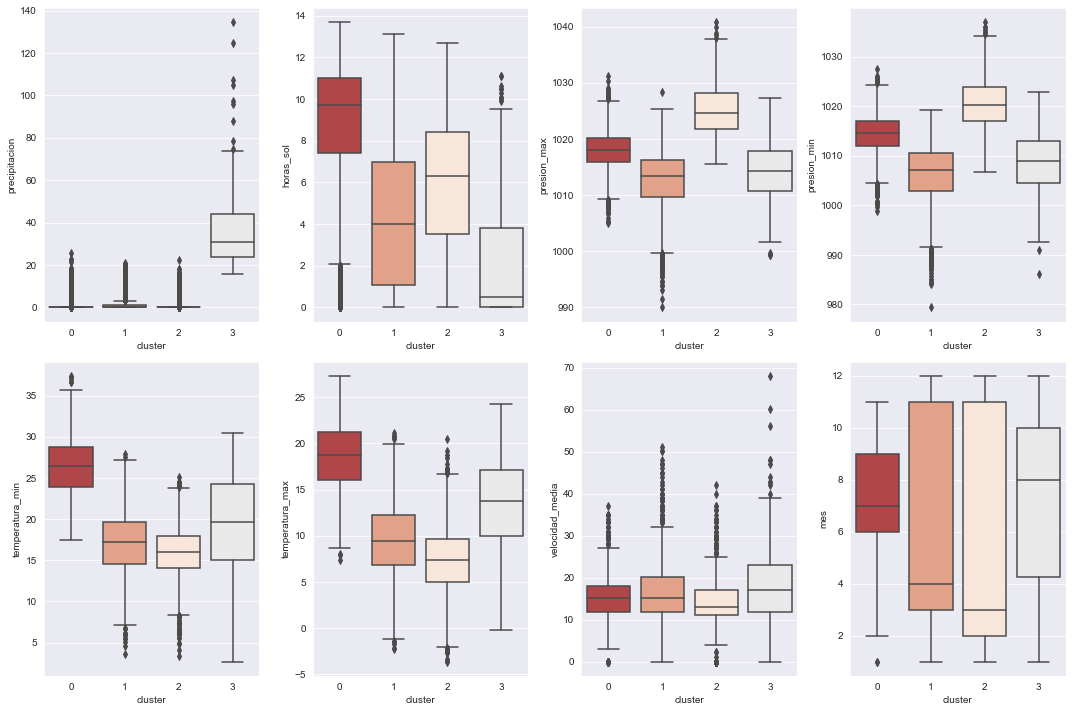

In [52]:
#sns.boxplot(df)
filas=2
columnas=4

# Figs, axes.
fig, axes = plt.subplots(filas, columnas, figsize=(15, 10),tight_layout=True)


# Plot histogramas
for i in range(filas):
    for j in range(columnas):
        var=(+j)+(i*columnas)
        sns.boxplot(ax = axes[i, j], 
                     data = DATA,  
                     y = DATA.columns[var],
                     x = 'cluster')

El cluster 3 agrupa todos los registros con valores de precipitaciones mayores de 19, con menor horas de insolación y con una mediana de velocidad del viento mayor.

El cluster 0 agrupa observaciones con un mayor promedio de horas de insolación, con temperaturas más altas y más concentrado en los meses de verano.

Los Cluster 1 y 2 están agrupados mayoritariamente en los primeros meses del año (aunque con registros de todo el año) son los clusters que registran menores temperaturas y una insolación intermedia y como diferencia el cluster 1 registra las presiones más bajas y el cluster 2 las presiones más altas del grupo.



## 4. Aprendizaje supervisado. Clasificación.

En este apartado voy a plantear un problema aprendizaje supervisado para el conjunto de datos. En concreto voy a plantear un algoritmo de clasificación que me permita predecir si habrá lluvia en función de las variables atmosféricas.

Para este caso voy a hacer una clasificación. Crearé una variable que se llame lluvia y tenga 2 clases. 
- **0**: No ha llovido.
- **1**: Si ha llovido.

Esta será mi variable objetivo.

In [81]:
# Lluvia -  
DATA['lluvia'] = 0
DATA.loc[DATA.precipitacion > 0, 'lluvia'] = 1


In [82]:
DATA.lluvia.value_counts()

0    8459
1    2234
Name: lluvia, dtype: int64

Para el ejercicio eliminaré los campos de precipitación y cluster que fue obtenido en el caso anterior con todo el dataset y que podría producir data leakage al pasar información del test.

In [83]:
DATA.drop(columns=['precipitacion','cluster'], inplace=True)

In [84]:
X = DATA.drop(columns = ['lluvia'])
y = DATA.lluvia

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 1984,
                                                    stratify = y)

In [86]:
X_train

,horas_sol,presion_max,presion_min,temperatura_min,temperatura_max,velocidad_media,mes,anio
fecha,,,,,,,,
2019-08-07,3.3,1012.0,1008.7,29.4,26.0,14.04,8,2019
1994-01-04,1.4,1017.2,1009.0,15.5,7.8,11.88,1,1994
2009-11-11,1.2,1012.2,1009.1,16.9,7.3,11.88,11,2009
1992-01-11,4.3,1023.2,1019.9,12.1,2.4,5.04,1,1992
2004-01-25,3.2,1018.7,1009.8,13.6,5.9,6.84,1,2004
...,...,...,...,...,...,...,...,...
2000-05-23,10.0,1020.0,1017.9,19.8,13.0,14.04,5,2000
2016-03-04,8.3,1012.9,997.3,15.9,7.3,19.08,3,2016
2020-09-14,10.8,1023.4,1020.9,29.6,19.4,14.04,9,2020


In [235]:
# Optuna wrapper to optimize 

def objective(trial):
    clf_name = trial.suggest_categorical('clf',['KNN', 'Log_Reg','Decision_tree'])
    
    if clf_name == 'KNN':
        kbest=trial.suggest_int('k',1,8)
        neighbors = trial.suggest_int('n_neighbors',3,95, step=2)
        weights_param = trial.suggest_categorical('weights',['uniform','distance'])
        
        clf_object = Pipeline(steps=[('Scaling', StandardScaler()),
                                     ('Kbest',SelectKBest(k=kbest)),
                                     ('KNN', KNeighborsClassifier(n_neighbors=neighbors,
                                                                  weights=weights_param)),
                                    ])
    
    elif clf_name == 'Log_reg':
        clf_object = Pipeline(steps=[('Scaling', StandardScaler()),
                                     ('Log_reg',LogisticRegression(max_iter = 500))
                                    ])
        
    
    
    else:
        profundidad = trial.suggest_int('max_depth',3,10, step=1)
        
        clf_object = Pipeline(steps=[('RFC',RFECV(estimator=DecisionTreeClassifier())),
                                     ('Decision_tree',DecisionTreeClassifier(max_depth=profundidad,
                                                                             random_state=1984,
                                                                             class_weight={0:2,1:8}))
                                    ])
    
    folds = StratifiedKFold(n_splits=5,)
    score = cross_val_score(clf_object,
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=folds)

    return score.mean()
        


In [236]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2021-07-16 11:10:35,144] A new study created in memory with name: no-name-0fff1dd0-28b8-49d2-b409-30bdbffcad7e
C:\Users\iukan\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2021-07-16 11:10:38,234] Trial 0 finished with value: 0.7413508826605109 and parameters: {'clf': 'Decision_tree', 'max_depth': 8}. Best is trial 0 with value: 0.7413508826605109.
[I 2021-07-16 11:10:38,509] Trial 1 finished with value: 0.828972866285542 and parameters: {'clf': 'KNN', 'k': 6, 'n_neighbors': 31, 'weights': 'uniform'}. Best is trial 1 with value: 0.828972866285542.
[I 2021-07-16 11:10:38,621] Trial 2 finished with value: 0.773671109779096 and parameters: {'clf': 'KNN', 'k': 1, 'n_neighbors': 65, 'weights': 'distance'}. Best is trial 1 with value: 0.828972866285542.
[I 2021-07-16 11:10:41,618] Trial 3 finished with value: 0.7674152114256354 and parameters: {'clf': 'Log_Reg', 'max_depth': 4}. Best is trial 1 with value: 0.828972866285542.
[I 2021-07-16 11:10:44,535] Trial 4 finished with value: 0.7674152114256354 and parameters: {'clf': 'Log_Reg', 'max_depth': 4}. Best is trial 1 with value: 0.828972866285542.
[I 2021-07-16 11:10:44,828] Trial 5 finished with value: 0.83

[I 2021-07-16 11:11:21,034] Trial 39 finished with value: 0.7607351981029573 and parameters: {'clf': 'Log_Reg', 'max_depth': 6}. Best is trial 17 with value: 0.8389673343520337.
[I 2021-07-16 11:11:24,064] Trial 40 finished with value: 0.7517492988208282 and parameters: {'clf': 'Decision_tree', 'max_depth': 9}. Best is trial 17 with value: 0.8389673343520337.
[I 2021-07-16 11:11:24,617] Trial 41 finished with value: 0.8379759550017981 and parameters: {'clf': 'KNN', 'k': 8, 'n_neighbors': 59, 'weights': 'distance'}. Best is trial 17 with value: 0.8389673343520337.
[I 2021-07-16 11:11:25,203] Trial 42 finished with value: 0.8384355034685415 and parameters: {'clf': 'KNN', 'k': 8, 'n_neighbors': 73, 'weights': 'distance'}. Best is trial 17 with value: 0.8389673343520337.
[I 2021-07-16 11:11:25,787] Trial 43 finished with value: 0.8384201393269068 and parameters: {'clf': 'KNN', 'k': 8, 'n_neighbors': 71, 'weights': 'distance'}. Best is trial 17 with value: 0.8389673343520337.
[I 2021-07-16 

[I 2021-07-16 11:11:53,063] Trial 77 finished with value: 0.8286989319401586 and parameters: {'clf': 'KNN', 'k': 5, 'n_neighbors': 87, 'weights': 'distance'}. Best is trial 49 with value: 0.8390024286394858.
[I 2021-07-16 11:11:53,730] Trial 78 finished with value: 0.8389673343520337 and parameters: {'clf': 'KNN', 'k': 8, 'n_neighbors': 95, 'weights': 'distance'}. Best is trial 49 with value: 0.8390024286394858.
[I 2021-07-16 11:11:56,898] Trial 79 finished with value: 0.7596452867137601 and parameters: {'clf': 'Decision_tree', 'max_depth': 7}. Best is trial 49 with value: 0.8390024286394858.
[I 2021-07-16 11:11:57,546] Trial 80 finished with value: 0.8382720429282733 and parameters: {'clf': 'KNN', 'k': 8, 'n_neighbors': 85, 'weights': 'distance'}. Best is trial 49 with value: 0.8390024286394858.
[I 2021-07-16 11:11:58,239] Trial 81 finished with value: 0.8387605644015899 and parameters: {'clf': 'KNN', 'k': 8, 'n_neighbors': 93, 'weights': 'distance'}. Best is trial 49 with value: 0.83

In [237]:
study.best_trial

FrozenTrial(number=49, values=[0.8390024286394858], datetime_start=datetime.datetime(2021, 7, 16, 11, 11, 31, 14090), datetime_complete=datetime.datetime(2021, 7, 16, 11, 11, 31, 684299), params={'clf': 'KNN', 'k': 8, 'n_neighbors': 89, 'weights': 'distance'}, distributions={'clf': CategoricalDistribution(choices=('KNN', 'Log_Reg', 'Decision_tree')), 'k': IntUniformDistribution(high=8, low=1, step=1), 'n_neighbors': IntUniformDistribution(high=95, low=3, step=2), 'weights': CategoricalDistribution(choices=('uniform', 'distance'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=49, state=TrialState.COMPLETE, value=None)

In [238]:
study.best_value

0.8390024286394858

In [239]:
study.best_params

{'clf': 'KNN', 'k': 8, 'n_neighbors': 89, 'weights': 'distance'}

In [240]:
clf_KNN = Pipeline(steps=[('Scaling', StandardScaler()),
                          ('Kbest',SelectKBest(k=8)),
                          ('KNN', KNeighborsClassifier(n_neighbors=89,
                                                       weights='distance', )),
                                                                            ])
    

In [241]:
clf_KNN.fit(X_train,y_train)

Pipeline(steps=[('Scaling', StandardScaler()), ('Kbest', SelectKBest(k=8)),
                ('KNN',
                 KNeighborsClassifier(n_neighbors=89, weights='distance'))])

In [242]:
y_pred = clf_KNN.predict(X_test)

In [244]:
roc_auc_score(y_test,y_pred)

0.6228084789058657

In [245]:
y_test.value_counts()

0    1692
1     447
Name: lluvia, dtype: int64

In [246]:
confusion_matrix(y_test,y_pred)

array([[1642,   50],
       [ 324,  123]], dtype=int64)

In [247]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1692
           1       0.71      0.28      0.40       447

    accuracy                           0.83      2139
   macro avg       0.77      0.62      0.65      2139
weighted avg       0.81      0.83      0.79      2139



Si aplicamos un algoritmo de clasificación tipo KNN obtenemos un modelo que funciona muy bien detectando los días que no llueve, y que cuando predice que va a llover acierta 2 de cada 3 veces. A continuación probaré con un algoritmo tipo random forest para ver si mejoramos la capacidad de detectar los días que llueve aunque perdamos precisión en la predicción en esa clase.

In [226]:
# Optuna wrapper to optimize 

def objective(trial):
    estimators = trial.suggest_int('n_estimators',100, 200, step=5)
    depth = trial.suggest_int('max_depth',2,9,step=1)
    
        
    clf_object = Pipeline(steps=[('RF', RandomForestClassifier(n_estimators=estimators, 
                                                                max_depth=depth,
                                                                class_weight='balanced_subsample')),
                                    ])
    
    folds = StratifiedKFold(n_splits=5,)
    score = cross_val_score(clf_object,
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=folds)

    return score.mean()
        


In [227]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2021-07-16 11:06:21,531] A new study created in memory with name: no-name-d467caf4-7c01-4923-a1b3-96b20fa2d7a6
C:\Users\iukan\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2021-07-16 11:06:25,661] Trial 0 finished with value: 0.8440304520829367 and parameters: {'n_estimators': 175, 'max_depth': 7}. Best is trial 0 with value: 0.8440304520829367.
[I 2021-07-16 11:06:28,470] Trial 1 finished with value: 0.8369107446630016 and parameters: {'n_estimators': 135, 'max_depth': 5}. Best is trial 0 with value: 0.8440304520829367.
[I 2021-07-16 11:06:33,337] Trial 2 finished with value: 0.8457207517023912 and parameters: {'n_estimators': 190, 'max_depth': 8}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:06:36,721] Trial 3 finished with value: 0.845442513796091 and parameters: {'n_estimators': 125, 'max_depth': 8}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:06:41,245] Trial 4 finished with value: 0.8443889347684893 and parameters: {'n_estimators': 185, 'max_depth': 7}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:06:45,678] Trial 5 finished with value: 0.8439474941236611 and parameters: {'n_estimators

[I 2021-07-16 11:09:03,049] Trial 43 finished with value: 0.8451353757238709 and parameters: {'n_estimators': 155, 'max_depth': 9}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:09:07,200] Trial 44 finished with value: 0.8442547451782069 and parameters: {'n_estimators': 160, 'max_depth': 8}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:09:12,111] Trial 45 finished with value: 0.8451944455073791 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:09:17,370] Trial 46 finished with value: 0.8454525250743619 and parameters: {'n_estimators': 195, 'max_depth': 8}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:09:22,237] Trial 47 finished with value: 0.8443453140115649 and parameters: {'n_estimators': 195, 'max_depth': 7}. Best is trial 2 with value: 0.8457207517023912.
[I 2021-07-16 11:09:27,367] Trial 48 finished with value: 0.8450486539153962 and parameters: {'n_est

In [228]:
study.best_trial

FrozenTrial(number=2, values=[0.8457207517023912], datetime_start=datetime.datetime(2021, 7, 16, 11, 6, 28, 472648), datetime_complete=datetime.datetime(2021, 7, 16, 11, 6, 33, 337085), params={'n_estimators': 190, 'max_depth': 8}, distributions={'n_estimators': IntUniformDistribution(high=200, low=100, step=5), 'max_depth': IntUniformDistribution(high=9, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)

In [229]:
study.best_value

0.8457207517023912

In [230]:
study.best_params

{'n_estimators': 190, 'max_depth': 8}

In [231]:
clf_RF = Pipeline(steps=[('RF', RandomForestClassifier(n_estimators=190, 
                                                       max_depth=8,
                                                       class_weight='balanced_subsample'),
                                                      )])
    

In [232]:
clf_RF.fit(X_train,y_train)
y_rf_pred = clf_RF.predict(X_test)

In [233]:
roc_auc_score(y_test,y_rf_pred)

0.752130039506878

In [234]:
confusion_matrix(y_test,y_rf_pred)

array([[1368,  324],
       [ 136,  311]], dtype=int64)

In [225]:
print(classification_report(y_test,y_rf_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1692
           1       0.49      0.65      0.56       447

    accuracy                           0.79      2139
   macro avg       0.70      0.74      0.71      2139
weighted avg       0.82      0.79      0.80      2139



Como habíamos visto en el notebook **02_EDA**, las clases están desbalanceadas, esto quiere decir que el número de días que llueve es mucho menor que el número de días que no llueve, en este caso en una proporción alrededor de 1 a 4. Por lo tanto el modelo tiende a ser más preciso prediciendo los días que no llueve.

Además habíamos visto que hay mucha variabilidad en los datos y poca correlación entre variables, salvo algún parámetro con correlaciones medias.

Para la predicción de el fenómeno lluvia voy a proponer el un modelo tipo Random Forest Classifier con 120 árboles y una profundidad máxima de 9. 

El modelo es capaz de detectar el 65% de los días que llueve y tiene se equivoca una vez de cada dos que predice lluvia.



## 5. Predicción de valores con librería prophet.

En el último apartado, voy a crear